## Step 1: Setup and Imports

We begin by setting the working directory and importing the custom processing functions defined in `SignalProcessingScripts.py`.

We also reload the module to ensure any changes to the code are reflected without restarting the kernel.

The `context` dictionary is used to store and pass data between steps.

In [1]:
%cd "/home/ammir/Desktop/Golem Seismic Processing/src/"
import golem as sps
import importlib
importlib.reload(sps)

context = {}

/home/ammir/Desktop/Golem Seismic Processing/src


/home/ammir/anaconda3/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


## Step 2: Load Seismic Data (Memory-Mapped)

We load a `.npy` file containing seismic shot gather data using NumPy's memory-mapping mode. This is efficient for large datasets as it avoids loading the full array into memory.


In [3]:
context['data']=sps.import_npy_mmap(file_in="/home/ammir/Desktop/Seismic Dataset/BP Benchmark 2004/Processed Data/KillTracesSeismogram.npy", mode="r")

## Step 3: Load Geometry Information

We read the geometry metadata from a `.parquet` file. This includes information like source and receiver positions, which we’ll use in later processing.


In [4]:
context['geometry']=sps.import_parquet_file(file_in="/home/ammir/Desktop/Seismic Dataset/BP Benchmark 2004/Processed Data/SourceReceiverGeometry.parquet")

## Step 4: Create Offset Header

We compute the **offset** between source and receiver positions using the expression:



In [5]:
sps.create_header(context, header_name="offset", expression="abs(SourceX - GroupX)")

,SourceX,SourceY,SourceZ,GroupX,GroupY,GroupZ,FFID,offset
0,37.5,0.0,12.5,0.0,0.0,12.5,1,37.5
1,37.5,0.0,12.5,12.5,0.0,12.5,1,25.0
2,37.5,0.0,12.5,25.0,0.0,12.5,1,12.5
3,37.5,0.0,12.5,37.5,0.0,12.5,1,0.0
4,87.5,0.0,12.5,0.0,0.0,12.5,2,87.5
...,...,...,...,...,...,...,...,...
1439243,67387.5,0.0,12.5,67337.5,0.0,12.5,1348,50.0
1439244,67387.5,0.0,12.5,67350.0,0.0,12.5,1348,37.5
1439245,67387.5,0.0,12.5,67362.5,0.0,12.5,1348,25.0
1439246,67387.5,0.0,12.5,67375.0,0.0,12.5,1348,12.5



This value is added as a new column in the geometry DataFrame.


## Step 5: Subset Geometry (offset == 0)

We filter the geometry to only include traces with zero offset — i.e., where/ the source and receiver are at the same location. The corresponding seismic traces are also filtered.

In [6]:
sps.subset_geometry_by_condition(context, condition="offset == 0")

,SourceX,SourceY,SourceZ,GroupX,GroupY,GroupZ,FFID,offset
3,37.5,0.0,12.5,37.5,0.0,12.5,1,0.0
11,87.5,0.0,12.5,87.5,0.0,12.5,2,0.0
23,137.5,0.0,12.5,137.5,0.0,12.5,3,0.0
39,187.5,0.0,12.5,187.5,0.0,12.5,4,0.0
59,237.5,0.0,12.5,237.5,0.0,12.5,5,0.0
...,...,...,...,...,...,...,...,...
1434443,67187.5,0.0,12.5,67187.5,0.0,12.5,1344,0.0
1435644,67237.5,0.0,12.5,67237.5,0.0,12.5,1345,0.0
1436845,67287.5,0.0,12.5,67287.5,0.0,12.5,1346,0.0
1438046,67337.5,0.0,12.5,67337.5,0.0,12.5,1347,0.0


## Step 6: Plot 2D Seismic Section

We visualize the filtered 2D seismic shot gather using `imshow`. The x-axis corresponds to receiver positions and the y-axis to time.

The amplitude is clipped at the 95th percentile for better contrast.


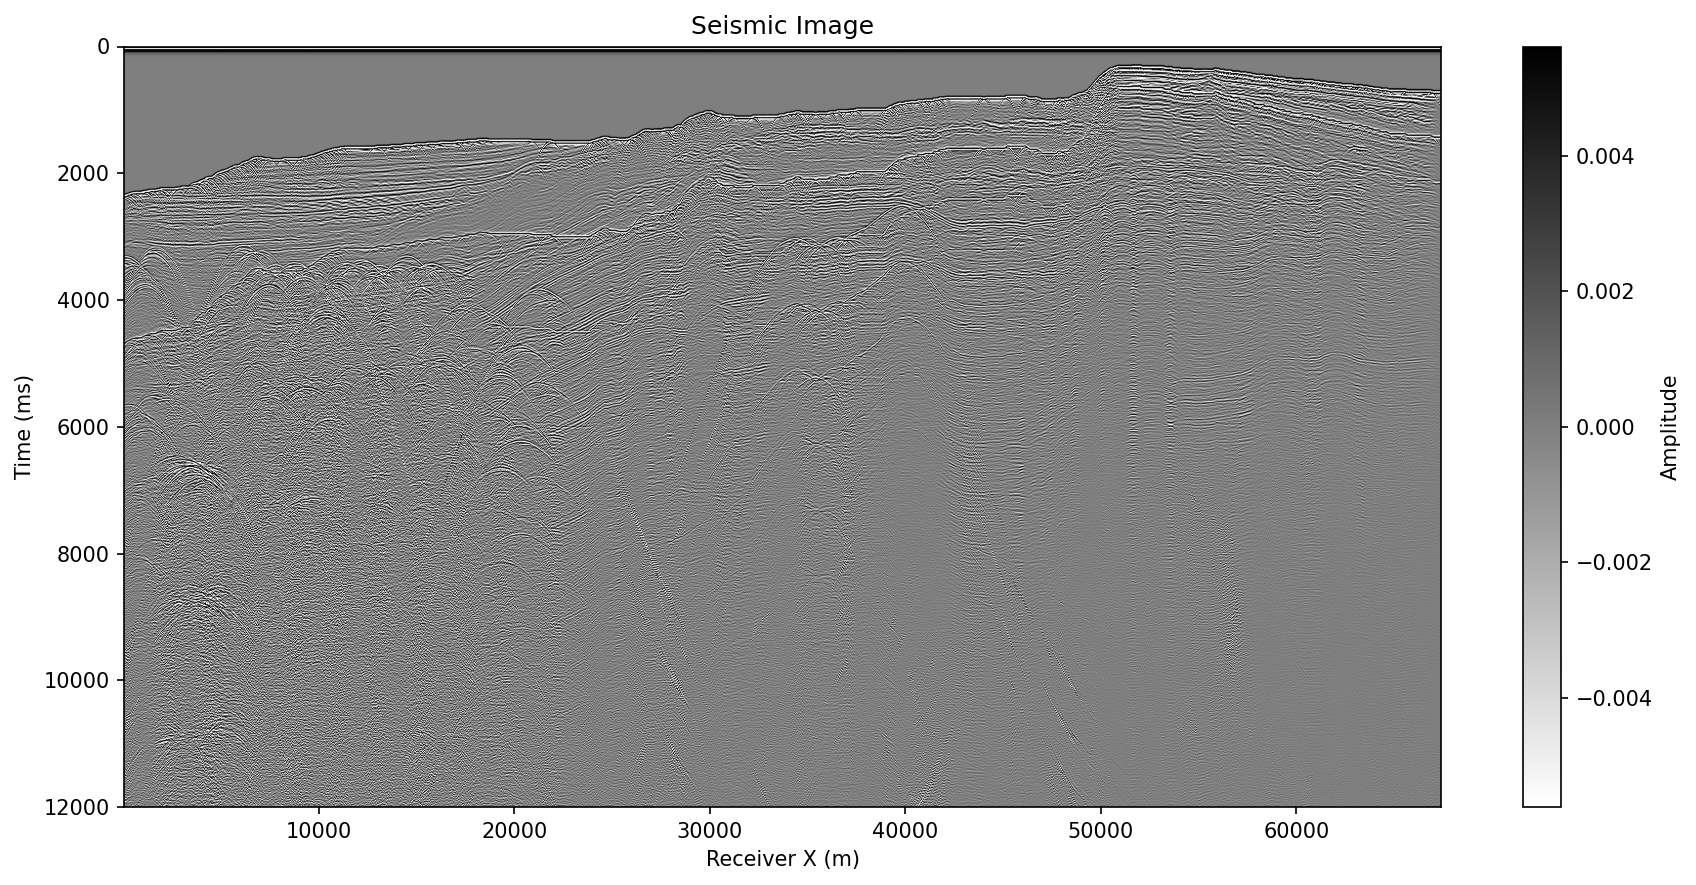

In [7]:
sps.plot_seismic_image(context,
    xlabel="Receiver X (m)",
    ylabel="Time (ms)",
    y_spacing=6.0,
    x_header="GroupX",
    perc=95
)

## Step 7: Stack Seismic Data Across Traces

We stack the traces along axis 1 (horizontally), averaging the amplitudes at each time sample. The result is a 1D seismic trace, often referred to as a stacked trace.


In [ ]:
sps.stack_data_along_axis(context, axis=1, method="mean")

## Step 8: Plot 1D Stacked Trace

We visualize the stacked trace as a vertical plot (time vs. amplitude). The y-axis represents time increasing downward, and the x-axis shows the amplitude.


In [ ]:
sps.plot_seismic_image(context,
    xlabel="Amplitude",
    ylabel="Time (ms)",
    y_spacing=6.0,
    x_header="GroupX",
    perc=95,
    xlim=[5000, 10000],
    ylim=[0, 100]
)

## Step 9: Mute Below a Given Sample

We apply a mute to the data by setting all values from a given sample index (e.g. 100) downward to zero. This helps remove low-frequency noise or unwanted late arrivals.


In [ ]:
sps.mute_data(context, start_sample=100)

## Step 10: Save Final Data to `.npy`

We save the processed 1D trace to a `.npy` file. The output filename includes the data shape, e.g. `_6001Samples.npy`, for clarity and traceability.


In [ ]:
sps.write_data(context,
    file_folder="/home/ammir/Desktop/Seismic Dataset/BP Benchmark 2004/ShotGather/Processed Data/",
    file_name="wavelet_BP2004_estimated",
    format="npy"
)